# ResNet For CIFAR0-10

In [1]:
!git status

On branch bill
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   DL_Mini_Proj.ipynb
	modified:   renet.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	__pycache__/
	rnn_torchviz
	rnn_torchviz.png

no changes added to commit (use "git add" and/or "git commit -a")


In [16]:
import torch
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchview import draw_graph

import os
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model Construction

Here we use torch build of ResNet18

In [3]:
import torch
import torch.nn as nn

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()

        # Branch 1: 1x1 convolution
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        # Branch 2: 1x1 convolution followed by 3x3 convolution
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)

        return torch.cat([branch1_out, branch2_out], 1)

class InceptionResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 1)
        self.layer2 = self._make_layer(128, 128, 2, stride=2)
        self.layer3 = self._make_layer(256, 256, 2, stride=2)
#         self.layer4 = self._make_layer(512, 512, 1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for _ in range(num_blocks):
            layers.append(InceptionModule(in_channels, out_channels))
            in_channels = out_channels * 2

        if stride == 2:
            layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Initialize the Inception-ResNet model

In [4]:
model = InceptionResNet(num_classes=10).to(device)

In [5]:
summary(model,(3, 32 , 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,160
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]           4,160
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
  InceptionModule-14            [-1, 12

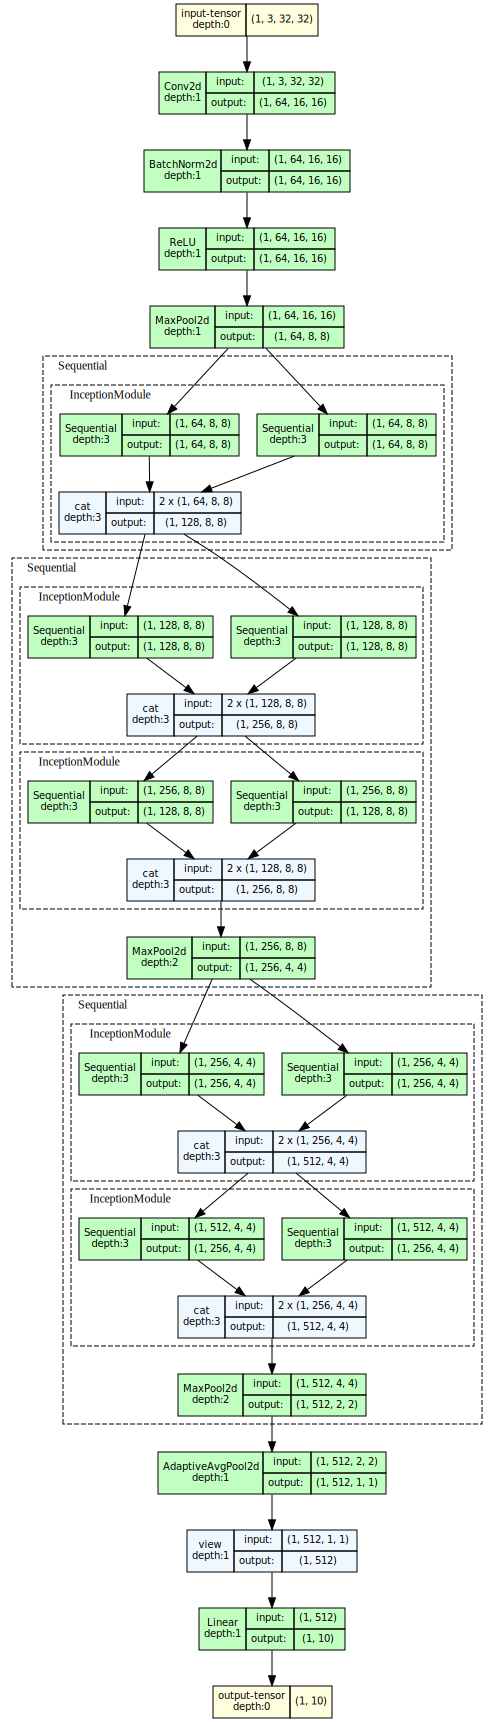

In [7]:
model_graph = draw_graph(model, input_size=(1, 3, 32 , 32), expand_nested=True)
model_graph.visual_graph

Construction Complete

### Data Preprocessing

In [17]:
def train_and_evaluate_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(num_epochs):
        # Training
        correct_train = 0
        total_train = 0
        epoch_train_loss = 0
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # Calculate train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            epoch_train_loss += loss.item()

        # Testing
        correct_test = 0
        total_test = 0
        epoch_test_loss = 0
        model.eval()
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate test accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                epoch_test_loss += loss.item()

        # Print train and test loss and accuracy for the current epoch
        epoch_train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        epoch_test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [18]:
dataTransform = transforms.Compose([
       transforms.RandomCrop(size=32, padding=4),
       transforms.RandomHorizontalFlip(p=0.5),
       transforms.ToTensor(),
       transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [19]:
trainset = torchvision.datasets.CIFAR10(
    root='/scratch/hx2214/data', train=True, download=True, transform=dataTransform) # change transform in future
trainLoader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='/scratch/hx2214/data', train=False, download=True, transform=dataTransform) # change transform in future
testLoader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
train_and_evaluate_model(model, trainLoader, testLoader)

Epoch [1/10], Train Loss: 1.4897, Train Accuracy: 45.82%, Test Loss: 1.2914, Test Accuracy: 54.76%
Epoch [2/10], Train Loss: 1.0752, Train Accuracy: 61.85%, Test Loss: 0.9292, Test Accuracy: 67.44%
Epoch [3/10], Train Loss: 0.8830, Train Accuracy: 69.16%, Test Loss: 0.9165, Test Accuracy: 68.38%
Epoch [4/10], Train Loss: 0.7653, Train Accuracy: 73.22%, Test Loss: 0.7781, Test Accuracy: 73.41%
Epoch [5/10], Train Loss: 0.6870, Train Accuracy: 76.05%, Test Loss: 0.7131, Test Accuracy: 75.63%
Epoch [6/10], Train Loss: 0.6289, Train Accuracy: 78.14%, Test Loss: 0.7220, Test Accuracy: 75.27%
Epoch [7/10], Train Loss: 0.5813, Train Accuracy: 79.73%, Test Loss: 0.6568, Test Accuracy: 77.91%
Epoch [8/10], Train Loss: 0.5449, Train Accuracy: 81.09%, Test Loss: 0.6332, Test Accuracy: 77.89%
Epoch [9/10], Train Loss: 0.5108, Train Accuracy: 82.28%, Test Loss: 0.6437, Test Accuracy: 78.27%
Epoch [10/10], Train Loss: 0.4838, Train Accuracy: 83.09%, Test Loss: 0.5954, Test Accuracy: 79.93%


In [21]:
! git add DL_Mini_Proj.ipynb

error: unknown switch `a'
usage: git add [<options>] [--] <pathspec>...

    -n, --dry-run         dry run
    -v, --verbose         be verbose

    -i, --interactive     interactive picking
    -p, --patch           select hunks interactively
    -e, --edit            edit current diff and apply
    -f, --force           allow adding otherwise ignored files
    -u, --update          update tracked files
    --renormalize         renormalize EOL of tracked files (implies -u)
    -N, --intent-to-add   record only the fact that the path will be added later
    -A, --all             add changes from all tracked and untracked files
    --ignore-removal      ignore paths removed in the working tree (same as --no-all)
    --refresh             don't add, only refresh the index
    --ignore-errors       just skip files which cannot be added because of errors
    --ignore-missing      check if - even missing - files are ignored in dry run
    --chmod (+|-)x        override the executable bit o